In [22]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import random

from keras.layers import Dense, InputLayer,Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
import pickle
import keras


In [23]:
# Initializing the category of classification
Categories = ["NORMAL", "PNEUMONIA"]

## Preparing Trainig Data

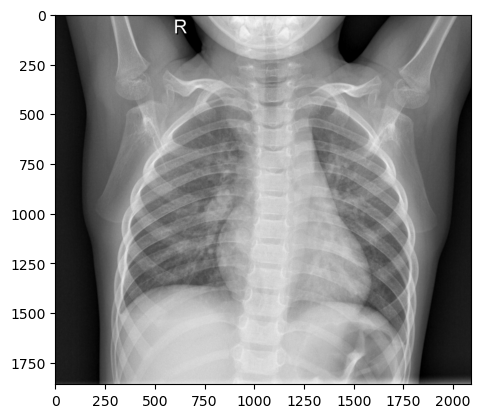

In [24]:
DataDir_Tranining = "chest_xray/train"

# Converting the image to Grayscale
for category in Categories:
    path = os.path.join(DataDir_Tranining, category)
    for img in os.listdir(path):
        imgs = os.path.join(path, img)
        img_array = cv2.imread(imgs, cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array, cmap="gray")
        plt.show()
        break
    break

In [25]:
img_size = 100 # Initializing the size of image

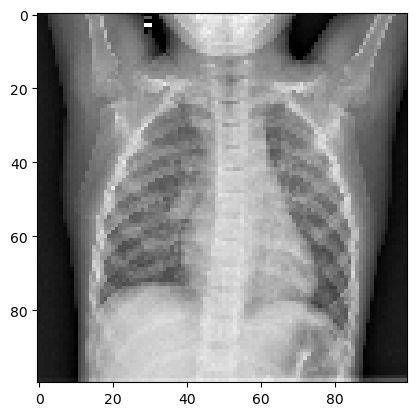

In [26]:
# Image after resizing and grayscale conversion
new_array = cv2.resize(img_array, (img_size, img_size))
plt.imshow(new_array, cmap="gray")
plt.show()


In [27]:
training_data = []

# Defining function for training data according to the categories converting the images into gray scale with resolution
# Converting the images into array

def create_train_data():
    for category in Categories:
        path = os.path.join(DataDir_Tranining, category)
        class_num = Categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (img_size, img_size))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass


create_train_data()
print(len(training_data))


5226


In [28]:
random.shuffle(training_data)

In [29]:
X_train = []
y_train = []

# Splitting the features and labels
for features, label in training_data:
    X_train.append(features)
    y_train.append(label)

In [30]:
X_train = np.array(X_train).reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

## Preparing Validation Data

In [ ]:
# We doing doing same with training data
validation_data = []
DataDir_Validation = "chest_xray/val"

def create_validation_data():
    for category in Categories:
        path = os.path.join(DataDir_Validation, category)
        class_num = Categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (img_size, img_size))
                validation_data.append([new_array, class_num])
            except Exception as e:
                pass

create_validation_data()
print(len(validation_data))

16


In [32]:
random.shuffle(validation_data)

In [33]:
X_val = []
y_val = []

for features, label in validation_data:
    X_val.append(features)
    y_val.append(label)


In [34]:

X_val = np.array(X_val).reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

## Preparing Testing Data

In [35]:
testing_data = []
DataDir_Testing = "chest_xray/test"
def create_test_data():
    for category in Categories:
        path = os.path.join(DataDir_Testing, category)
        class_num = Categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (img_size, img_size))
                testing_data.append([new_array, class_num])
            except Exception as e:
                pass

create_test_data()
print(len(testing_data))


624


In [36]:
random.shuffle(testing_data)

In [37]:
X_test = []
y_test = []

for features, label in testing_data:
    X_test.append(features)
    y_test.append(label)

In [38]:
X_test = np.array(X_test).reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

## Model Building

In [39]:
X_train = X_train/255.0
X_val = X_val/255.0
X_test = X_test/255.0


In [40]:

def Pneumnia_Classifier(input_shape):
    model = Sequential()

    model.add(Conv2D(64, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(.2))

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model



In [ ]:
BATCH_SIZES = [2, 4, 16, 32, 64]
EPOCHS_LIST = [10, 20, 30]

# BATCH_SIZES = [2]
# EPOCHS_LIST = [5]
results = []
best_acc = -1
best_training_acc = -1
best_validation_acc = -1
best_info = None
input_size =X_train.shape[1:]

In [42]:
for ep in EPOCHS_LIST:
    for bs in BATCH_SIZES:
        print(f"Starting run: batch_size={bs}, epochs={ep}")
        tf.keras.backend.clear_session()
        m = Pneumnia_Classifier(input_size)
        history = m.fit(X_train, y_train, batch_size=bs,epochs=ep, validation_data=(X_val, y_val), verbose=1)
        acc_mean = round(np.mean(history.history['accuracy']) * 100, 2)
        acc_val_mean = round(np.mean(history.history['val_accuracy']) * 100, 2)
        score = m.evaluate(X_test, y_test, verbose=0)
        curr_acc = round(score[1] * 100, 2)
        results.append((bs, ep, acc_mean, acc_val_mean, curr_acc))
        if curr_acc > best_acc:
            best_acc = curr_acc
            best_training_acc = acc_mean
            best_validation_acc = acc_val_mean
            best_info = f'Batch_Size : {bs}, Epochs : {ep}, Training_Accuracy : {best_training_acc}, Validation_Accuracy : {best_validation_acc}, Test_Accuracy : {best_acc}'

Starting run: batch_size=2, epochs=5


c:\Users\alokp\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 128s 48ms/step - accuracy: 0.8628 - loss: 0.3670 - precision: 0.8708 - recall: 0.9575 - val_accuracy: 0.8750 - val_loss: 0.2817 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 2/5
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 89s 34ms/step - accuracy: 0.9380 - loss: 0.1777 - precision: 0.9525 - recall: 0.9647 - val_accuracy: 0.9375 - val_loss: 0.2324 - val_precision: 0.8889 - val_recall: 1.0000
Epoch 3/5
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 91s 35ms/step - accuracy: 0.9428 - loss: 0.1657 - precision: 0.9612 - recall: 0.9619 - val_accuracy: 0.7500 - val_loss: 0.5113 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 4/5
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 94s 36ms/step - accuracy: 0.9506 - loss: 0.1346 - precision: 0.9644 - recall: 0.9694 - val_accuracy: 0.9375 - val_loss: 0.1741 - val_precision: 0.8889 - val_recall: 1.0000
Epoch 5/5
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 96s 37ms/step - accuracy: 0.9613 - loss: 0.1138 - precision: 0.9752 - recall: 0.9727 - val_accuracy: 0.812

In [43]:
print("Best Result -> ", best_info)

Best Result ->  Batch_Size : 2, Epochs : 5, Training_Accuracy : 93.11, Validation_Accuracy : 86.25, Test_Accuracy : 74.36


In [44]:
df = pd.DataFrame(results, columns=['Batch_Size', 'Epochs', 'Training_Accuracy', 'Validation_Accuracy', 'Test_Accuracy'])
df.head()

,Batch_Size,Epochs,Training_Accuracy,Validation_Accuracy,Test_Accuracy
0,2,5,93.11,86.25,74.36


In [45]:
df.to_csv('Performance_Report.csv')

In [46]:
m.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 98, 98, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 49, 49, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 47, 47, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 21, 21, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,276,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,964,741 (41.83 MB)

 Trainable params: 3,654,913 (13.94 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,309,828 (27.88 MB)

In [47]:
model_name = f'Model/Pneumonia_Detection_CNN_{round(best_acc, 0)}.h5'
tf.keras.models.save_model(m, model_name)